In [1]:
from datetime import datetime, timedelta
from datetime import time
from math import sqrt
from pathlib import Path
from typing import Callable, Optional

import numpy as np
import pandas as pd
from category_encoders import BinaryEncoder
from matplotlib import pyplot as plt
from scipy.interpolate import Akima1DInterpolator

from utils.data import prepare_dataset_for_training

In [2]:
n_functions = 1
timesteps_in = 4
n_nodes = 10
n_small_dataset_nodes = 10

small_dataset_suffix = f"_{n_small_dataset_nodes}sd" if n_small_dataset_nodes > 0 else ""

base_dataset_folder = Path(f"data/datasets/{n_functions}func_{n_nodes}nodes_3k{small_dataset_suffix}")
base_network_folder = Path(f"data/networks/{n_nodes}_nodes_3k")

In [3]:
start_date = datetime(2018, 1, 1)
small_dataset_nodes_start_date = datetime(2018, 12, 20)
end_date = datetime(2019, 1, 1)
freq="15min"

In [4]:
# margins (longitude and latitude) of the portion of the city considered for the experiment
with open("data/BBox.txt") as f:
    (LON_MIN, LON_MAX, LAT_MIN, LAT_MAX) = eval(f.readline())

LON_CENTRE = (LON_MIN + LON_MAX) / 2
LAT_CENTRE = (LAT_MAX + LAT_MIN) / 2

MAX_DIST = sqrt((LAT_MAX-LAT_CENTRE)**2 + (LON_MAX - LON_CENTRE)**2)

### Generate time-related "ideal" trend

In [5]:
def smooth_function_from_time_datapoints(timestamps: list[float], data_points: list[float]) -> Callable[[float], float]:
    cs = Akima1DInterpolator([i for i in timestamps], data_points)
    return cs

In [6]:
def generate_weekday_timestamps(
        start_date: datetime,
        end_date: datetime,
        target_time: time,
        only_weekdays: tuple[int] = ()
) -> list[float]:
    date_times = []
    current_date = start_date

    while current_date <= end_date:
        if not only_weekdays or current_date.weekday() in only_weekdays:
            target_datetime = datetime.combine(current_date, target_time)
            date_times.append(target_datetime)

        current_date += timedelta(days=1)

    return [t.timestamp() for t in date_times]

In [7]:
def generate_time_trend_function(
        start: datetime,
        end: datetime,
        work_morning_value: float,
        work_afternoon_value: float,
        weekend_morning_value: float,
        weekend_afternoon_value: float,
        weekend_night_value: float,
) -> Callable[[float], float]:
    workdays = (0,1,2,3,4)
    weekend_days = (5, 6)
    weekend_night = (4, 5)

    work_mornings = generate_weekday_timestamps(start, end, target_time=time(8, 0), only_weekdays=workdays)
    work_afternoon = generate_weekday_timestamps(start, end, target_time=time(17, 30), only_weekdays=workdays)
    weekend_morning = generate_weekday_timestamps(start, end, target_time=time(10, 30), only_weekdays=weekend_days)
    weekend_afternoon = generate_weekday_timestamps(start, end, target_time=time(16, 0), only_weekdays=weekend_days)
    weekend_night = generate_weekday_timestamps(start, end, target_time=time(21, 30), only_weekdays=weekend_night)


    timestamps = np.array([
        *work_mornings, *work_afternoon, *weekend_morning, *weekend_afternoon, *weekend_night,
    ])

    values = np.concatenate((
        np.repeat(work_morning_value, len(work_mornings)),
        np.repeat(work_afternoon_value, len(work_afternoon)),
        np.repeat(weekend_morning_value, len(weekend_morning)),
        np.repeat(weekend_afternoon_value, len(weekend_afternoon)),
        np.repeat(weekend_night_value, len(weekend_night)),
    ))

    ordered_ind = np.argsort(timestamps)

    ordered_ts = timestamps[ordered_ind]
    ordered_val = values[ordered_ind]

    return smooth_function_from_time_datapoints(
        timestamps=list(ordered_ts),
        data_points=list(ordered_val),
    )


In [8]:
def get_traffic_function(base_traffic: int) -> Callable[[float], int]:
    min_coeff = np.random.uniform(0, 1)
    max_coeff = np.random.uniform(1, 3)
    increase_in_centre = np.random.choice([True, False])
    
    if increase_in_centre:
        def func(dist: float) -> int:
            # max_coeff if dist=0, min_coeff if d=1, scale proportionally in the middle
            coeff = max_coeff-(max_coeff-min_coeff)*dist
            return base_traffic * coeff
        return func
    else:
        def func(dist: float) -> int:
            # min_coeff if dist=0, max_coeff if d=1, scale proportionally in the middle
            coeff = min_coeff+(max_coeff-min_coeff)*dist
            return base_traffic * coeff
        return func
    

def get_tower_ideal_trends(
    start_date: datetime,
    end_date: datetime,
    freq:str,
    n_functions: int,
    towers: pd.DataFrame,
    small_dataset_nodes_start_date: datetime,
    small_dataset_nodes: tuple[int, ...] = (),
) -> list[pd.DataFrame]:
    index = pd.date_range(start=start_date, end=end_date, freq=freq)
    small_dataset_index = pd.date_range(start=small_dataset_nodes_start_date, end=end_date, freq=freq)
    function_column_names = [f"fn_{i}" for i in range(n_functions)]
    
    tower_ideal_trends = [
        pd.DataFrame(index=small_dataset_index if i in small_dataset_nodes else index, columns=function_column_names)
        for i in range(n_nodes)
    ]
    
    base_fn = 500
    work_morning_fn = get_traffic_function(base_fn)
    work_evening_fn = get_traffic_function(base_fn)
    weekend_morning_fn = get_traffic_function(base_fn)
    weekend_afternoon_fn = get_traffic_function(base_fn)
    weekend_night_fn = get_traffic_function(base_fn)

    for tower_i in range(n_nodes):
        distance_from_centre = towers["distance"][tower_i]
        time_function = generate_time_trend_function(
            start=small_dataset_nodes_start_date if tower_i in small_dataset_nodes else start_date,
            end=end_date + timedelta(days=1), # add some delay to allow for lags in other functions
            work_morning_value=work_morning_fn(distance_from_centre),
            work_afternoon_value=work_evening_fn(distance_from_centre),
            weekend_morning_value=weekend_morning_fn(distance_from_centre),
            weekend_afternoon_value=weekend_afternoon_fn(distance_from_centre),
            weekend_night_value=weekend_night_fn(distance_from_centre),
        )
        
        function_series = np.array([
            time_function(t.timestamp()) for t in (small_dataset_index if tower_i in small_dataset_nodes else index)
        ])
        
    

        tower_ideal_trends[tower_i]["fn_0"] = function_series
        
    for i in range(1, n_functions):
        lag = np.random.randint(-4, -1)
        k = np.random.uniform(0.5, 2)
        for tower_i in range(n_nodes):
            tower_ideal_trends[tower_i][f"fn_{i}"] = tower_ideal_trends[tower_i]["fn_0"].shift(lag) * k

    return tower_ideal_trends



In [9]:
def plot_univariate_time_series(
    x_values: list[datetime],
    y_values: list[float],
    title: str,
    x_label: str = "Time",
    y_label: str= "Value",
    start_from: int = 0,
    end: int = None,
) -> None:
    plt.plot(x_values[start_from:end], y_values[start_from:end])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
def generate_multivariate_ar_time_series(size: int, p: int, num_variables, mean: float = 0, std: float = 1, alpha: float = 0.1, ar_coefficients: Optional[np.ndarray] = None):
    if ar_coefficients is None:
        ar_coefficients = np.random.uniform(-0.8, 0.8, (num_variables, p))

    # Initialize with random values
    time_series = np.random.normal(mean, std, (size, num_variables))

    for i in range(p, size):
        for var in range(num_variables):
            ar_value = np.sum(ar_coefficients[var] * time_series[i-p:i, var])
            new_value = ar_value + np.random.normal(mean, std)
            time_series[i, var] = new_value

        # Regularize coefficients to reduce chance of divergence
        ar_coefficients = (1 - alpha) * ar_coefficients

    return time_series

def plot_multivariate_time_series(
        time_series: pd.DataFrame,
        title: str = None,
        xlabel: str = "Time",
        ylabel: str = "Value",
        start_from: int = 0,
        end: Optional[int] = None,
        show_variables: tuple[int, ...] = (),
) -> None:
    plt.figure(figsize=(10, 6))

    
    time_index = time_series.index[start_from:end]
    
    values = time_series.to_numpy()

    num_variables = time_series.shape[1]
    for var in range(num_variables):
        if var in show_variables:
            plt.plot(time_index, values[start_from:end, var], label=f"Function {var}")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
def get_tower_real_trends(tower_ideal_trends: list[pd.DataFrame]) -> list[pd.DataFrame]:
    tower_real_trends = []

    # use same coefficients for all nodes within the same simulation
    ar_coefficients = np.random.uniform(-0.8, 0.8, (n_functions, timesteps_in))

    for ideal_trend in tower_ideal_trends:
        time_series = generate_multivariate_ar_time_series(
            size=len(ideal_trend),
            p=timesteps_in,
            num_variables=n_functions,
            ar_coefficients=ar_coefficients,
        )

        # point-wise mult
        tower_real_trend = 0.05 * time_series * ideal_trend + ideal_trend.to_numpy()

        start = 200 # cut away first negative values of the smooth function

        tower_real_trends.append(pd.DataFrame(
            tower_real_trend[start:],
            columns=[f"fn_{i}" for i in range(n_functions)],
            index=ideal_trend.index[start:],
        ))

    return tower_real_trends

### Clipping

In [12]:
def clip_datasets(tower_real_trends: list[pd.DataFrame]) -> list[pd.DataFrame]:
    for i, trend in enumerate(tower_real_trends):
        quantiles = trend.quantile(0.95)
        tower_real_trends[i] = trend.clip(np.zeros(n_functions), quantiles, axis=1)
    return tower_real_trends

### Scaling in [0, 1]

In [13]:
def scale_datasets(tower_real_trends: list[pd.DataFrame]) -> list[pd.DataFrame]:
    max_values = pd.DataFrame(
        trend.max()
        for trend in tower_real_trends
    ).max()

    for i, trend in enumerate(tower_real_trends):
        tower_real_trends[i] = trend / max_values

    return tower_real_trends

### Encode time

In [14]:
def encode_time(df: pd.DataFrame) -> pd.DataFrame:
    df["hour"] = df.index.hour
    df["weekday"] = df.index.weekday
    return BinaryEncoder(cols=["hour", "weekday"]).fit_transform(df)

### Generate datasets

In [15]:
for i in range(5):
    dataset_folder = Path(base_dataset_folder / str(i))
    dataset_folder.mkdir(parents=True, exist_ok=True)

    towers = pd.read_csv(base_network_folder / str(i) / "towers.csv")
    towers["distance"] = ((towers["lon"]-LON_CENTRE)**2 + (towers["lat"]-LAT_CENTRE)**2).apply(sqrt) / MAX_DIST

    small_dataset_nodes = np.random.choice(
        n_nodes,
        size=n_small_dataset_nodes,
        replace=False, 
    )
    
    if n_small_dataset_nodes > 0:
        with open(dataset_folder / "info.txt", "w") as f:
            print(f"[{', '.join(small_dataset_nodes)}]", file=f)

    time_ideal_trends = get_tower_ideal_trends(
        start_date=start_date,
        end_date=end_date,
        freq=freq,
        towers=towers,
        n_functions=n_functions,
        small_dataset_nodes=small_dataset_nodes,
        small_dataset_nodes_start_date=small_dataset_nodes_start_date,
    )

    real_trends = get_tower_real_trends(time_ideal_trends)

    real_trends = clip_datasets(real_trends)
    real_trends = scale_datasets(real_trends)

    real_trends = [
        encode_time(trend)
        for trend in real_trends
    ]

    for i, trend in enumerate(real_trends):
        trend = trend.dropna()
        trend.to_parquet(dataset_folder / f"node_{i}.parquet")

    prepare_dataset_for_training(
        dataset_folder=dataset_folder,
        n_nodes=n_nodes,
        input_timesteps=timesteps_in,
        output_timesteps=1,
        n_functions=n_functions,
        n_auxiliary_features=8,
    )

/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thes

Saved!


/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thes

Saved!


/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thes

Saved!


/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thes

Saved!


/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thesis-workspace/gossip_learning_simulator/.venv/lib/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/Users/personal/Documents/thes

Saved!


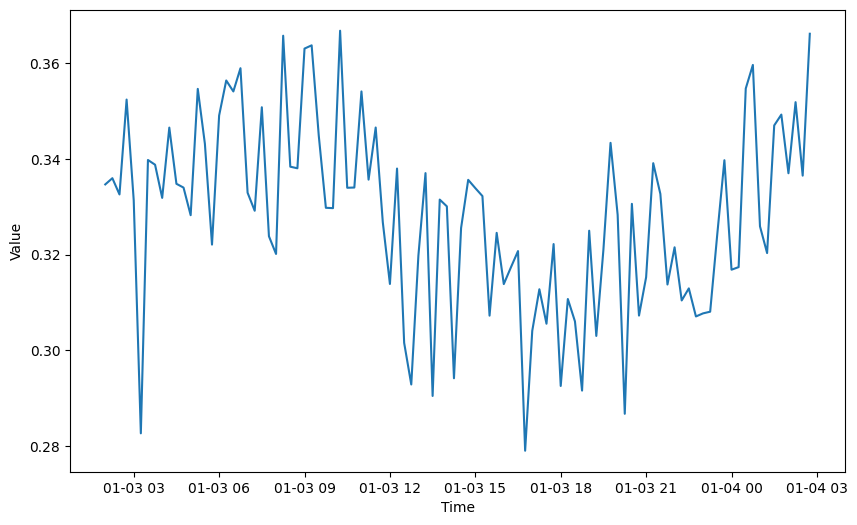

In [16]:
plot_multivariate_time_series(
    real_trends[0],
    show_variables=(0,),
    start_from=0,
    end=100,
)

In [17]:
from utils.data import load_npz_data

_, Y_train, _, _, _, _ = load_npz_data("data/datasets/3func_10nodes_3k/3/4in/node_1.npz")

In [18]:
df = pd.DataFrame(data={
    "fn_1": Y_train[:,:,0].flatten(),
    "fn_2": Y_train[:,:,1].flatten(),
    "fn_3": Y_train[:,:,2].flatten(),
}, index = pd.date_range(start=start_date, end=None, freq=freq, periods=len(Y_train)))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
plot_multivariate_time_series(df, show_variables=(0,1,2), start_from=500, end=800)

In [ ]:
df = real_trends[4][["fn_0", "fn_1", "fn_2"]].diff().dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller(Y_train[:, :, 0])

In [ ]:
import pandas as pd
df = pd.DataFrame(Y_train[:, :, 0], columns=["col1"])

In [ ]:
df["col1"].autocorr(lag=2)

In [ ]:
ser = generate_multivariate_ar_time_series(
    size=1000, 
    p=4,
    num_variables=1,
)

In [ ]:
df = pd.DataFrame(ser, columns=["col1"])

In [ ]:
df["col1"].autocorr(lag=4)

In [ ]:
np.random.randint(-4, -1)